In [13]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline


In [2]:
yield_data = pd.read_csv('FRB_H15.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2009-11-30']


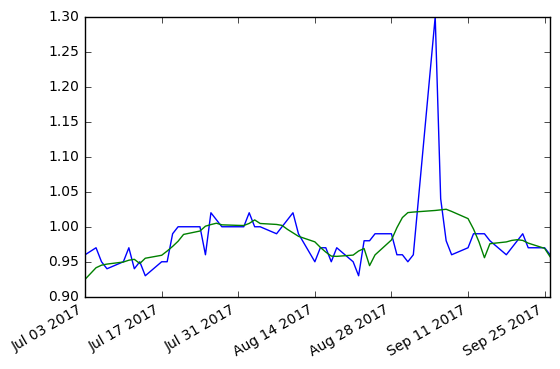

In [3]:
##savgol_filter polynomial filter
yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data.iloc[:,:11]).transpose(),15,3).transpose())
yield_data_filtered.columns = yield_data.iloc[:,:11].columns
yield_data_filtered.index = yield_data.index
yield_data_filtered.head()
yield_data[yield_data.index >'2017-07-01']['1-month'].astype(np.float32).plot()
yield_data_filtered[yield_data_filtered.index >'2017-07-01']['1-month'].astype(np.float32).plot()

In [4]:
def rolling_method(df,col,window):
    method = ['mean','std','median','min','max']
    a = df[col].rolling(window=window)
    b = pd.concat([getattr(a,k)() for k in method],axis=1)
    b.columns  = method
    #b['RMS'] = a.apply(lambda y: np.sqrt(np.mean(y**2)))
    #b['crest'] = 0.5*(b['max']-b['min'])/b['RMS']
    #b['crossing'] = a.apply(lambda y: len(np.where(np.diff(y - np.mean(y)))[0]))/window
    #b['slope'] = a.apply(lambda y: linregress(range(window),y)[0])
    b.columns = [col + '_'+ k +'_'+str(window)+'day' 
                 for k in ['mean','std','median','min','max'#,'RMS','crest','crossing','slope'
                          ]]
    return b

In [5]:
yield_data_features=pd.concat([rolling_method(yield_data_filtered,i,j) \
                               for i in yield_data_filtered.columns[:11] \
                               for j in [3,7,15,20]],axis=1).shift(11) 
# 11 beacuse first shift 1 and then shift 10 as rolling window of 20 from 10th to 30th day
yield_data_features.head(10)


,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,30-year_mean_15day,30-year_std_15day,30-year_median_15day,30-year_min_15day,30-year_max_15day,30-year_mean_20day,30-year_std_20day,30-year_median_20day,30-year_min_20day,30-year_max_20day
2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
yield_data_features=pd.concat([yield_data_features,yield_data],axis=1)
#yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()
for i in range(1,11):
    temp=yield_data_features[[col for col in yield_data_filtered.columns]].shift(i)
    temp.columns=[j+'_'+str(i) for j in list(temp.columns)]
    yield_data_features=pd.concat([yield_data_features,temp],axis=1)
yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,3-month_10,6-month_10,1-year_10,2-year_10,3-year_10,5-year_10,7-year_10,10-year_10,20-year_10,30-year_10
2010-01-14,0.022769,0.004435,0.022860,0.018290,0.027158,0.017537,0.005568,0.014833,0.012579,0.027158,...,0.05,0.19,0.45,1.08,1.65,2.61,3.34,3.8,4.54,4.61
2010-01-15,0.026842,0.003833,0.027158,0.022860,0.030507,0.019903,0.007096,0.018290,0.012579,0.030507,...,0.06,0.2,0.47,1.14,1.7,2.69,3.39,3.85,4.58,4.63
2010-01-19,0.029729,0.002283,0.030507,0.027158,0.031520,0.022535,0.007552,0.022860,0.012579,0.031520,...,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.6,4.65
2010-01-20,0.031173,0.000578,0.031493,0.030507,0.031520,0.025237,0.006736,0.027158,0.014833,0.031520,...,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-21,0.031116,0.000677,0.031493,0.030335,0.031520,0.027452,0.005093,0.030335,0.018290,0.031520,...,0.06,0.15,0.4,1.01,1.6,2.6,3.33,3.85,4.63,4.7


In [20]:
def predictLSTM(target):
    print("******************",target,"***********************")
    seed(1)
    Y=yield_data_features[[target]]
    X=yield_data_features.drop(target,axis=1)
    
    X_train=X[X.index < '2017-06-01']
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_train=X_train_scaled
    X_test=X[X.index >= '2017-06-01']
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    X_test=X_test_scaled
    y_train=Y[Y.index < '2017-06-01']
    y_test=Y[Y.index  >= '2017-06-01']
    index=y_test.index
    # drop index
    X_train.reset_index(inplace=True)
    X_train.drop('index',axis=1,inplace=True)
    X_test.reset_index(inplace=True)
    X_test.drop('index',axis=1,inplace=True)
    y_train.reset_index(inplace=True)
    y_train.drop('index',axis=1,inplace=True)
    y_test.reset_index(inplace=True)
    y_test.drop('index',axis=1,inplace=True)
    #transfor to 3d input that lstm expects
    XtrainArr=X_train.as_matrix()
    XtestArr=X_test.as_matrix()
    y_train=y_train.as_matrix()
    y_test=y_test.as_matrix()
    train_X = XtrainArr.reshape((XtrainArr.shape[0], 1, XtrainArr.shape[1]))
    test_X = XtestArr.reshape((XtestArr.shape[0], 1, XtestArr.shape[1]))
    
    print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)
    #init model
    model = Sequential()
    model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
    
    ##kickout below since makes things worse
    #model.add(Dense(3, activation = 'relu'))
    #model.add(Dropout(.1))
    ##model.add(Dense(2, activation = 'relu'))
    
    model.add(Dense(1))
    model.compile(loss='mae',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # fit network
    history = model.fit(train_X, y_train, nb_epoch=500, batch_size=1000, 
                        validation_data=(test_X, y_test), verbose=0, shuffle=False)
    # plot history
    ypred = model.predict(test_X)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    print('RMSE=',mean_squared_error(y_test,ypred))
    ###plot true and predict
    final=pd.DataFrame()
    final['Time']=index
    final.index=index
    final['true']=y_test
    final['pred']=ypred
    plt.figure(figsize=(8, 6))
    s = 25
    a = 0.4
    plt.figure(figsize=(8,3))
    x_axis=range(len(final))
    plt.scatter(x_axis, final['true'], edgecolor='k',
            c="navy", s=s, alpha=a, label="Data")
    plt.scatter(x_axis, final['pred'], edgecolor='k',
            c="c", s=s, alpha=a,
            label="LSTM (R2score={:.2f} \n RMSE={:.2f})".format(r2_score(y_test,ypred),
                                                              np.sqrt(mean_squared_error(y_test,ypred))))
    plt.xticks(x_axis, final['Time'].dt.date, rotation='vertical', fontsize = 6)
    plt.xlabel("date")
    
    plt.ylabel(target+" yield")
    plt.gca().margins(x=0)
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

****************** 1-month ***********************


/Users/lakshyagarg/Downloads/ENTER/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lakshyagarg/Downloads/ENTER/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


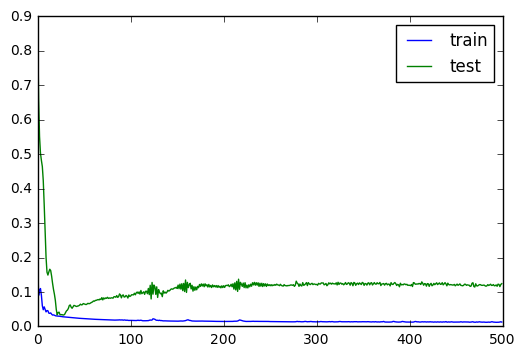

RMSE= 0.0192608578603


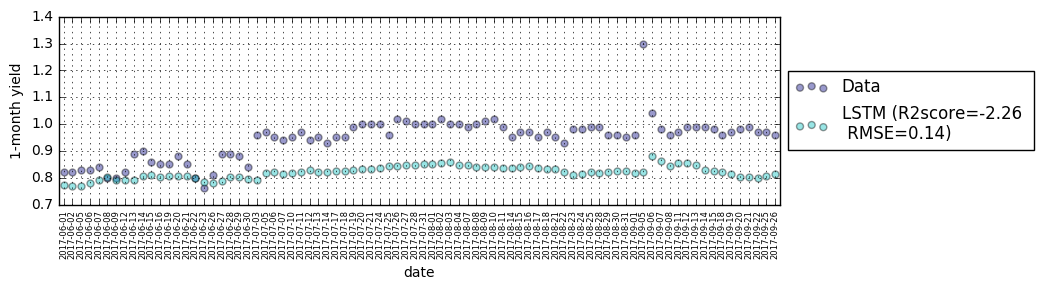

****************** 3-month ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


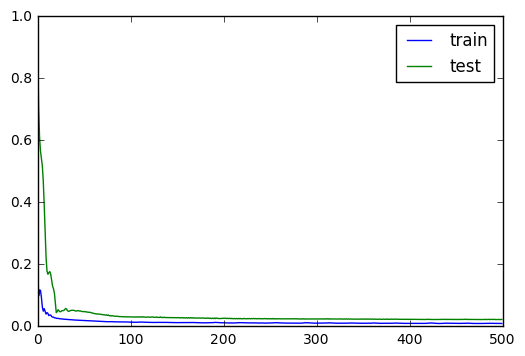

RMSE= 0.00111357639577


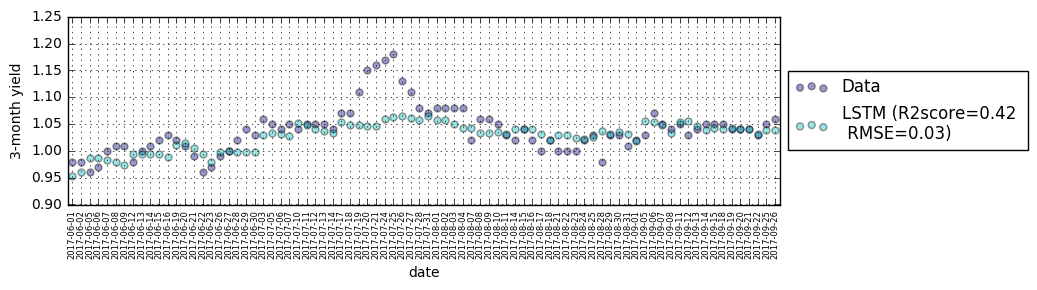

****************** 6-month ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


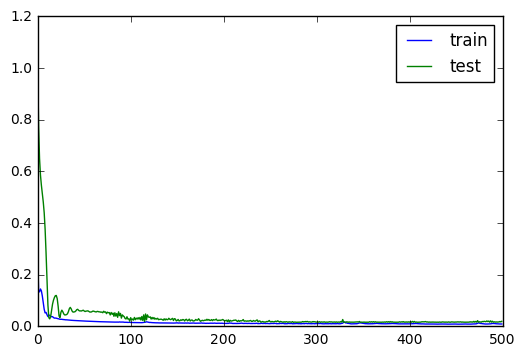

RMSE= 0.000568187173758


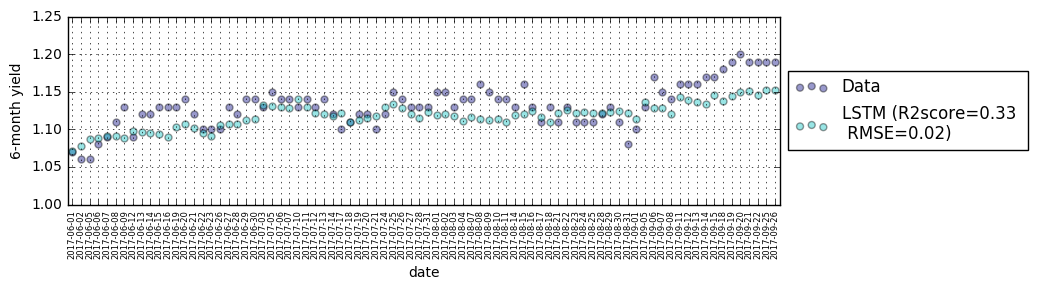

****************** 1-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


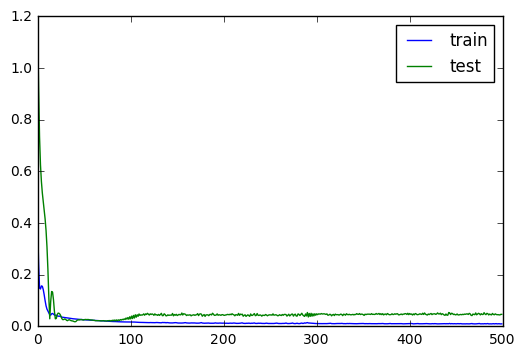

RMSE= 0.00281577279537


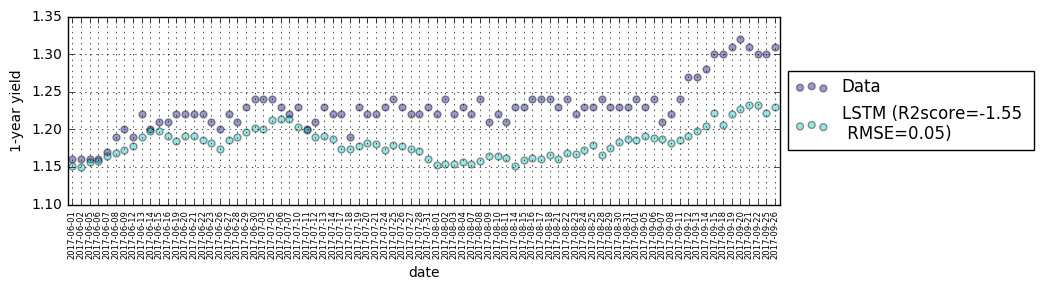

****************** 2-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


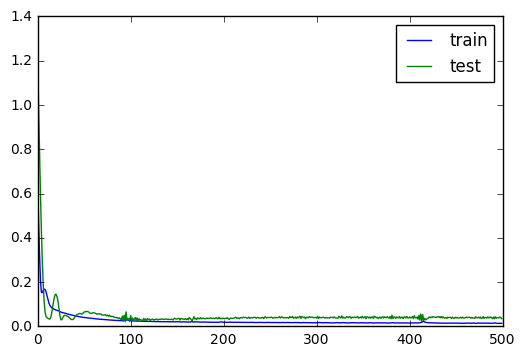

RMSE= 0.00166596566852


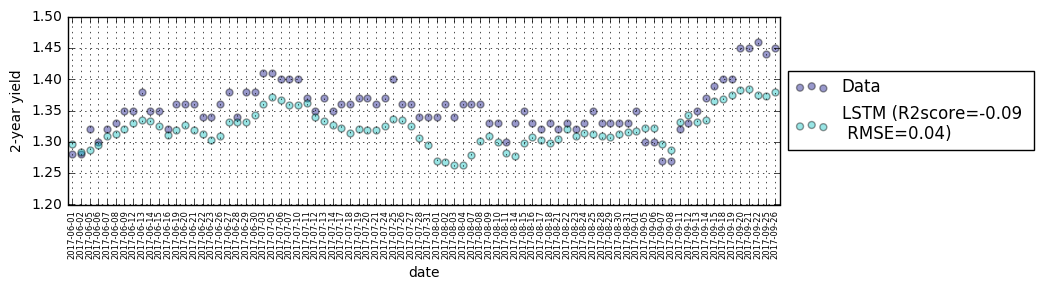

****************** 3-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


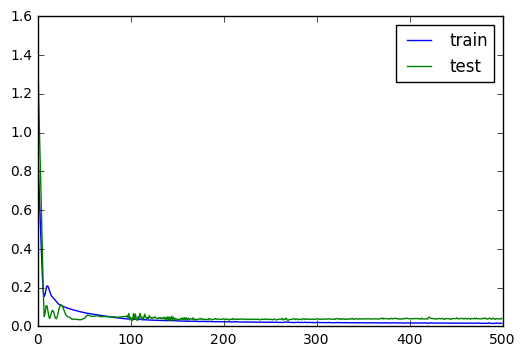

RMSE= 0.00242848928557


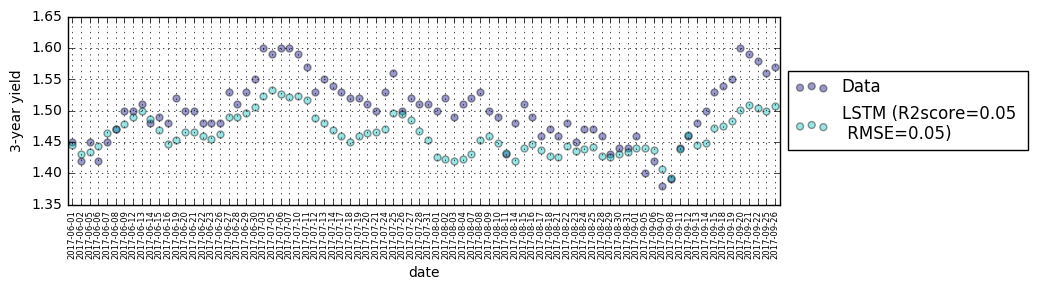

****************** 5-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


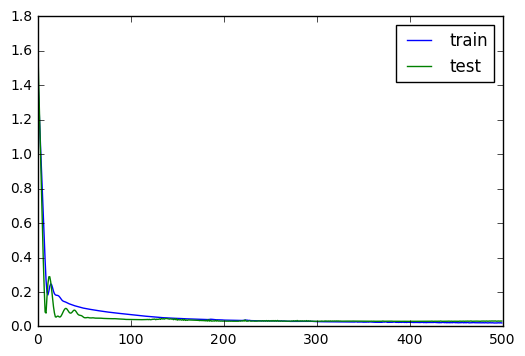

RMSE= 0.00150876875593


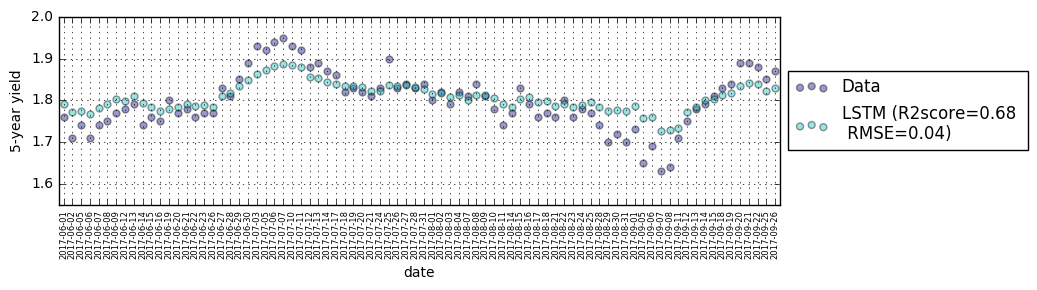

****************** 7-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


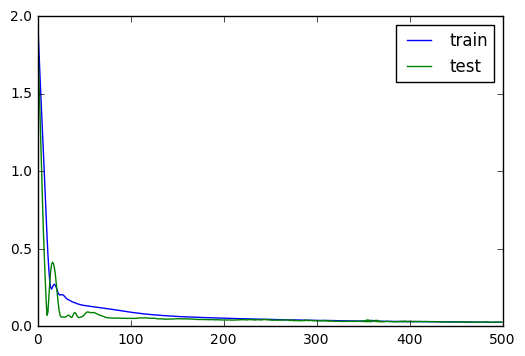

RMSE= 0.00105860706131


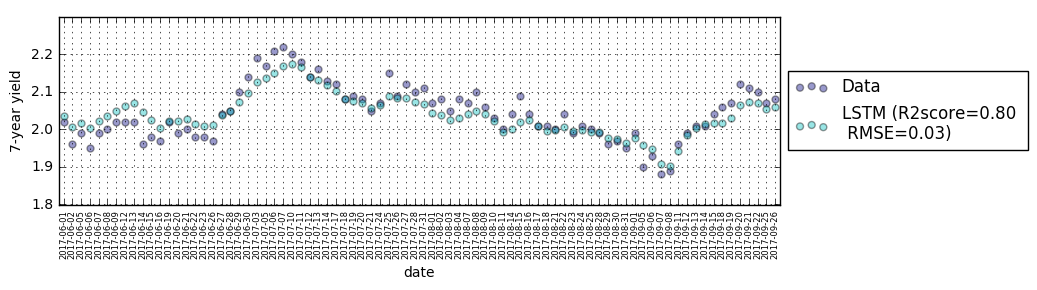

****************** 10-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


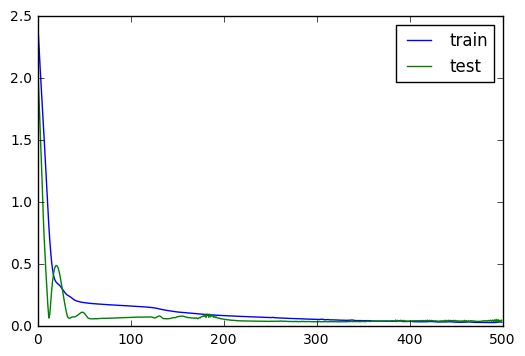

RMSE= 0.00310231404803


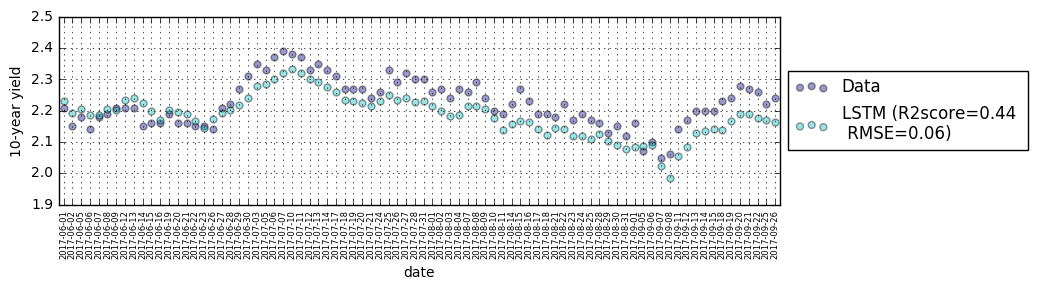

****************** 20-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


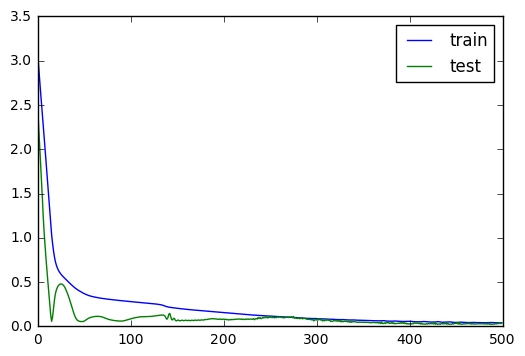

RMSE= 0.00237647924825


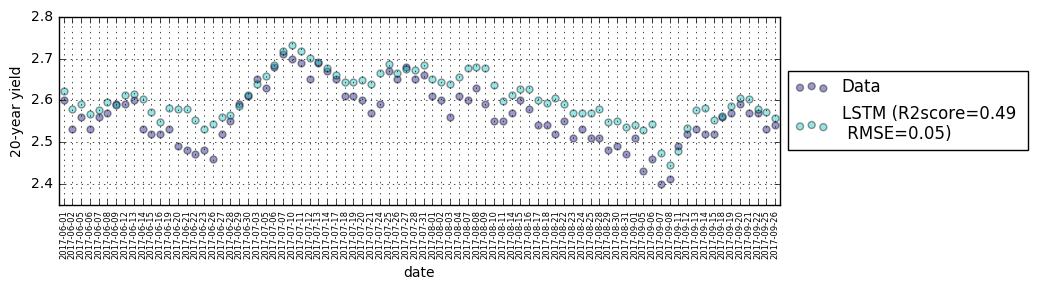

****************** 30-year ***********************
(1847, 1, 342) (1847, 1) (82, 1, 342) (82, 1)


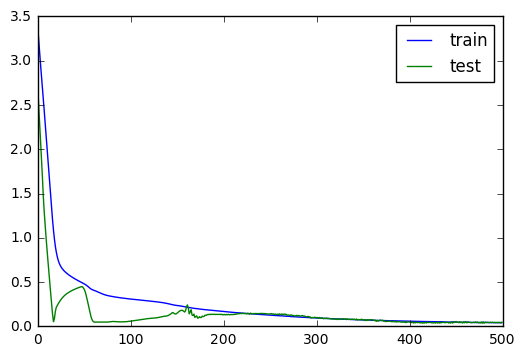

RMSE= 0.00322269986845


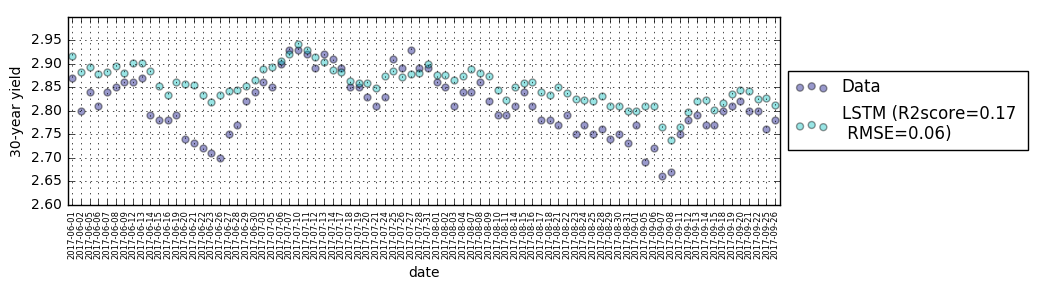

In [21]:

for target in ['1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year','7-year', '10-year', '20-year', '30-year']: 
    predictLSTM(target)
    